# 음식배달에 걸리는 시간 예측하기

Time 2 vec : https://towardsdatascience.com/time2vec-for-time-series-features-encoding-a03a4f3f937e

https://ojus1.github.io/posts/time2vec/

In [20]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline

In [21]:
data = pd.read_csv('./delivery_raw.csv',sep='\t')
print('=============결측치 개수=============')
print(f'총 데이터 개수 : {len(data)}개')
for key in data.keys():
    num = data[key].isna().sum()
    if num: print(f'{key} : {num}')

=============결측치 개수=============
총 데이터 개수 : 197428개
market_id : 987
actual_delivery_time : 7
store_primary_category : 4760
order_protocol : 995
total_onshift : 16262
total_busy : 16262
total_outstanding_orders : 16262
estimated_store_to_consumer_driving_duration : 526


## 결측치 처리
- market_id : 지역번호로 987개밖에 없으므로 삭제 or 랜덤
- actual_delivery_time : 예측해야하는 값이므로 dropna
- store_primary_category : 음식종류로 unique값은 74개이며 결측치 4760개가 아깝긴 하지만 drop?
- order_protocol : 주문방법으로 unique값은 7개 , 995개의 결측치 drop?
- total_onshift,busy,outstanding_orders : 결측치가 엄청 많음 drop하긴 아까움 -> ?????????????????????????

In [22]:
# 결측치 제거

data_lenth = len(data)
#data.dropna(axis=0, how='any', subset=['actual_delivery_time','market_id','order_protocol','store_primary_category'], inplace=True) 
data.dropna(axis=0, how='any', subset=data.columns, inplace=True)      # 도착시간이 null인경우 해당 raw삭제
data_lenth -= len(data)
print(f'{data_lenth}개의 null data 삭제')

#data.dropna(axis=0, how='any', subset=['market_id'], inplace=True)   
#data['market_id'].fillna(value=np.random.randint(1,7), inplace=True)

21651개의 null data 삭제


In [23]:
# 날짜 datetime 변환 및 target 만들기
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['target'] = (data['actual_delivery_time'] - data['created_at']).dt.seconds
data = data[data['target']<10000]

- 주문날짜는 2015-01~02
## 범주형
1. 명목형 : market_id, store_id, store_primary_category, order_protocol , 요일
2. 순서형

## 수치형
1. 이산형 : total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift, total_busy, total_outstanding_orders
2. 연속형 : created_at, estimated_store_to_consumer_driving_duration, estimated_order_place_duration , 주문 시간

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175606 entries, 0 to 197427
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175606 non-null  float64       
 1   created_at                                    175606 non-null  datetime64[ns]
 2   actual_delivery_time                          175606 non-null  datetime64[ns]
 3   store_id                                      175606 non-null  int64         
 4   store_primary_category                        175606 non-null  object        
 5   order_protocol                                175606 non-null  float64       
 6   total_items                                   175606 non-null  int64         
 7   subtotal                                      175606 non-null  int64         
 8   num_distinct_items                            175606 n

## 데이터 전처리
- 날짜 , 범주형 데이터 , 수치형 데이터로 나눔
    - 범주형 데이터에 날짜도 포함시키기

    
날짜 -> 년 월 일 시간으로 나누기
임베딩을 위해선 범주화 해야함

In [25]:
# hour, minute 추출 후 주문시간 만들기 + 요일 만들기

data['hour'] = data['created_at'].apply(lambda x: x.hour).astype('category')            # 9~13이 없음
data['minute'] = data['created_at'].apply(lambda x: x.minute).astype('category')        # 0~59 모두 있음
data['order_time'] = data['created_at'].apply(lambda x: (60*x.hour + x.minute) if x.hour>10 else (60*(x.hour+24) + x.minute))
data['day_of_week'] = data['created_at'].apply(lambda x: x.day_name()).astype('category')

In [26]:
# 수치형 변수
numeric_features = ['total_items','subtotal','num_distinct_items','min_item_price','max_item_price','total_onshift','total_busy',
                    'total_outstanding_orders','estimated_order_place_duration','estimated_store_to_consumer_driving_duration','order_time']

X_data_numeric = np.stack([data[col] for col in numeric_features],1)
print(f'수치형 데이터 : {X_data_numeric.shape}')

# 범주형 변수
categorical_features = ['market_id','store_id','store_primary_category','order_protocol','day_of_week']
day_of_week_dic = {'Monday': 0,'Tuesday': 1,'Wednesday': 2,'Thursday': 3,'Friday': 4,'Saturday': 5,'Sunday': 6}
store_id_dic = {}
for i,v in enumerate(sorted(data['store_id'].unique())):
    store_id_dic[v] = i

def convert_to_int_day(day):                # 요일
    return day_of_week_dic[day]
def convert_to_int_category(category):      # 음식 카테고리
    return pd.factorize(category)[0]
def convert_to_int_store_id(store_id):
    return store_id_dic[store_id]

data['market_id'] = data['market_id'] - 1                                                   # market_id
data['store_id'] = data['store_id'].apply(convert_to_int_store_id)                          # store_id
data['store_primary_category'] = convert_to_int_category(data['store_primary_category'])    # store_primary_category
data['order_protocol'] = data['order_protocol'] - 1                                         # order_protocol
data['day_of_week'] = data['day_of_week'].apply(convert_to_int_day)                         # 요일
X_data_categorical = np.stack([data[col] for col in categorical_features],1)
print(f'범주형 데이터 : {X_data_categorical.shape}')


# 최종 데이터 & 타겟 값
X_data = np.concatenate((X_data_categorical,X_data_numeric),axis=1)
y_data = np.array(data['target']).reshape(-1,1)
print(X_data.shape,y_data.shape)



# 임베딩을 위한 범주형 데이터 차원
categorical_features_size = [len(data[col].unique()) for col in categorical_features]
categorical_features_size = [(n,min(100,(n+1)//2)) for n in categorical_features_size]
print(categorical_features_size)

수치형 데이터 : (175606, 11)
범주형 데이터 : (175606, 5)
(175606, 16) (175606, 1)
[(6, 3), (5644, 100), (73, 37), (7, 4), (7, 4)]


In [27]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X_data, y_data,test_size=0.2, shuffle=True)
X_val , X_test , y_val , y_test = train_test_split(X_test, y_test,test_size=0.5, shuffle=True)

X_train , y_train = torch.tensor(X_train,dtype=torch.float32) , torch.tensor(y_train,dtype=torch.float32)
X_val , y_val = torch.tensor(X_val,dtype=torch.float32) , torch.tensor(y_val,dtype=torch.float32)
X_test , y_test = torch.tensor(X_test,dtype=torch.float32) , torch.tensor(y_test,dtype=torch.float32)
print(X_train.shape,y_train.shape)

# 데이터로더
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

torch.Size([140484, 16]) torch.Size([140484, 1])


In [28]:
# 모델 생성

class Model(nn.Module):
    def __init__(self, embedding_size, layers,layer_size=10, p=0.4,categorical_size=5,numeric_size=11):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.dropout = nn.Dropout(p)
        self.categorical_size = categorical_size
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        self.input_batch = nn.BatchNorm1d(numeric_size)

        all_layers = []
        input_size_t = num_categorical_cols+numeric_size
        for i in layers:
            all_layers.append(nn.Linear(input_size_t, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size_t = i
        all_layers.append(nn.Linear(layers[-1], layer_size))
        self.layers = nn.Sequential(*all_layers)
        self.outlayer = nn.Linear(layer_size, 1)

    def forward(self, x):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x[:,i].long()))
        x1 = torch.cat(embeddings, 1)
        x2 = self.input_batch(x[:,self.categorical_size:])
        x = torch.cat((x1,x2),1)
        x = self.dropout(x)
        x = self.layers(x)
        x = self.outlayer(x)
        return x

In [29]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [30]:
model = Model(categorical_features_size,[200,100,50], p=0.2)
model.to(device)
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse_loss = nn.MSELoss()
        rmse_loss = torch.sqrt(mse_loss(y_pred, y_true))
        return rmse_loss
RMSEloss = RMSELoss()

class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        mse_loss = nn.MSELoss(reduction='none')                                            # 각 요소별로 MSE 계산
        result = torch.where(y_pred < y_true, torch.tensor(4.0), torch.tensor(1.0))
        weighted_loss = result * mse_loss(y_pred, y_true)                                  # 각 요소별로 가중치 적용된 손실 계산
        summed_loss = torch.sum(weighted_loss)                                             # 손실 값들을 합산
        rmse_loss = torch.sqrt(summed_loss/y_true.shape[0])                                                # RMSE 계산
        return rmse_loss
Myloss = MyLoss()

In [31]:
Epoch = 40
train_rmseloss , valid_rmseloss = [] , []           # rmse를 추적
train_uprate , valid_uprate = [] , []               # uprate추적
train_myloss , valid_myloss = [] , []               # 가중치를 준 loss추적

for epoch in range(1,Epoch+1):
    total_rmseloss , total_count , total_myloss = 0 , 0 , 0
    model.train()
    for data, y in train_loader:
        data , y = data.to(device) , y.to(device)
        output = model(data)
        rmseloss , myloss = RMSEloss(output, y) , Myloss(output,y)
        optimizer.zero_grad()
        myloss.backward()
        optimizer.step()

        count = torch.sum(output < y)
        total_rmseloss += len(data)*rmseloss.item()
        total_count += count.item()
        total_myloss += len(data)*myloss.item()

    total_rmseloss /= len(train_loader.dataset)
    total_count /= len(train_loader.dataset)
    total_myloss /= len(train_loader.dataset)

    train_rmseloss.append(total_rmseloss)
    train_uprate.append(total_count)
    train_myloss.append(total_myloss)
    print(f'Epoch{epoch} train_loss:{total_myloss:.2f} ({100*total_count:.0f}%)',end='  ')

    total_rmseloss , total_count , total_myloss = 0 , 0 , 0
    model.eval()
    with torch.no_grad():
        for data, y in valid_loader:
            data , y = data.to(device) , y.to(device)
            output = model(data)
            rmseloss , myloss = RMSEloss(output, y) , Myloss(output,y)

            count = torch.sum(output < y)
            total_rmseloss += len(data)*rmseloss.item()
            total_count += count.item()
            total_myloss += len(data)*myloss.item()

        total_rmseloss /= len(valid_loader.dataset)
        total_count /= len(valid_loader.dataset)
        total_myloss /= len(valid_loader.dataset)

        valid_rmseloss.append(total_rmseloss)
        valid_uprate.append(total_count)
        valid_myloss.append(total_myloss)
        print(f'valid_loss:{total_myloss:.2f} ({100*total_count:.0f}%)')
    torch.save(model.state_dict(), os.path.join('./model_data/', '{0:0=2d}.pth'.format(epoch)))
    


Epoch1 train_loss:2939.94 (57%)  valid_loss:1425.97 (23%)
Epoch2 train_loss:1464.30 (25%)  valid_loss:1405.21 (22%)
Epoch3 train_loss:1444.87 (25%)  valid_loss:1397.67 (23%)
Epoch4 train_loss:1426.96 (25%)  valid_loss:1400.02 (24%)
Epoch5 train_loss:1418.56 (25%)  valid_loss:1400.02 (27%)
Epoch6 train_loss:1400.44 (25%)  valid_loss:1396.85 (25%)
Epoch7 train_loss:1392.59 (25%)  valid_loss:1379.89 (23%)
Epoch8 train_loss:1384.36 (25%)  valid_loss:1381.29 (25%)
Epoch9 train_loss:1378.11 (25%)  valid_loss:1374.19 (24%)
Epoch10 train_loss:1370.32 (25%)  valid_loss:1373.09 (23%)
Epoch11 train_loss:1363.50 (25%)  valid_loss:1374.47 (26%)
Epoch12 train_loss:1356.30 (25%)  valid_loss:1378.07 (25%)
Epoch13 train_loss:1354.54 (25%)  valid_loss:1370.11 (24%)
Epoch14 train_loss:1348.87 (25%)  valid_loss:1387.10 (28%)
Epoch15 train_loss:1342.59 (25%)  valid_loss:1380.23 (28%)
Epoch16 train_loss:1339.27 (25%)  valid_loss:1367.54 (25%)
Epoch17 train_loss:1337.88 (25%)  valid_loss:1367.79 (23%)
Epoch1

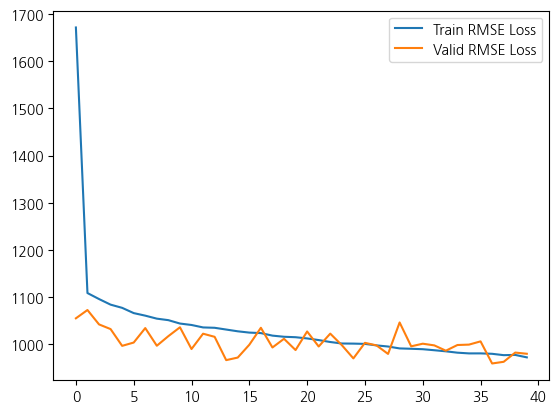

In [32]:
sns.lineplot(train_rmseloss, label='Train RMSE Loss')
sns.lineplot(valid_rmseloss, label='Valid RMSE Loss')
plt.legend()
plt.show()

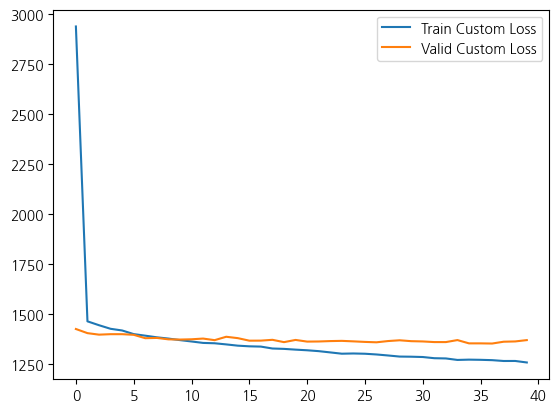

In [33]:
sns.lineplot(train_myloss, label='Train Custom Loss')
sns.lineplot(valid_myloss, label='Valid Custom Loss')
plt.legend()
plt.show()

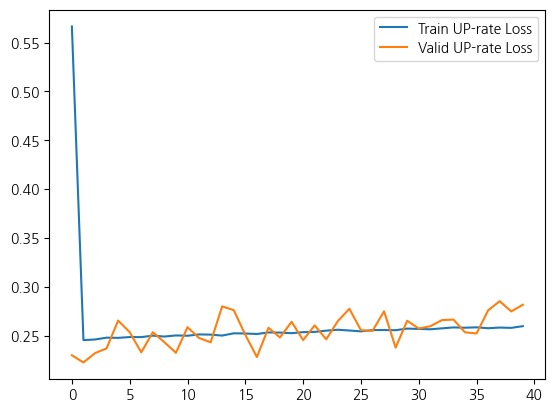

In [34]:
sns.lineplot(train_uprate, label='Train UP-rate Loss')
sns.lineplot(valid_uprate, label='Valid UP-rate Loss')
plt.legend()
plt.show()

In [35]:
# test
best_epoch = np.argmin(np.array(valid_myloss)) + 1
print(f'최적의 epoch는 {best_epoch}')
model.load_state_dict(torch.load(os.path.join('./model_data/', '{0:0=2d}.pth'.format(best_epoch))))
model.eval()

total_rmseloss , total_count , total_myloss = 0 , 0 , 0
model.eval()
with torch.no_grad():
    for data, y in test_loader:
        data , y = data.to(device) , y.to(device)
        output = model(data)
        rmseloss , myloss = RMSEloss(output, y) , Myloss(output,y)

        count = torch.sum(output < y)
        total_rmseloss += len(data)*rmseloss.item()
        total_count += count.item()
        total_myloss += len(data)*myloss.item()

total_rmseloss /= len(test_loader.dataset)
total_count /= len(test_loader.dataset)
total_myloss /= len(test_loader.dataset)
print(f'test_loss:{total_myloss:.2f} up_rate:{100*total_count:.0f}% RMSEloss:{total_rmseloss:.2f}')

최적의 epoch는 37
test_loss:1350.76 up_rate:27% RMSEloss:956.90


결론 : RMSE는 956.9
Under-prediction의 비율 : 27%